In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sb
import datetime as dt


%matplotlib inline

Load the data

In [2]:


dataFrame=pd.read_csv('../data/train.csv')

Get some data statistics


In [3]:
print "Column Names:"
print dataFrame.columns.values
print "=============================="
mean = np.mean(dataFrame['trip_duration'])
print "Mean trip duration =",mean
print "Standard deviation for trip duration =",np.std(dataFrame['trip_duration'])
print "Minimum trip duration = ",np.min(dataFrame['trip_duration'])
print "Maximum trip duration = ",np.max(dataFrame['trip_duration'])

print "Sample data frame row:"
print dataFrame[:1]

Column Names:
['id' 'vendor_id' 'pickup_datetime' 'dropoff_datetime' 'passenger_count'
 'pickup_longitude' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'store_and_fwd_flag' 'trip_duration']
Mean trip duration = 959.49227296
Standard deviation for trip duration = 5237.42992919
Minimum trip duration =  1
Maximum trip duration =  3526282
Sample data frame row:
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937          -73.96463   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  


The difference between minimum and maximum trip duration seems to be huge. This is even stranger considering the fact that the duration is in seconds, so its not possible that there was a 1 second trip and its higly unlikely that a trip which lasted 3.5M seconds. Lets see the histogram to analyze the data distribution.

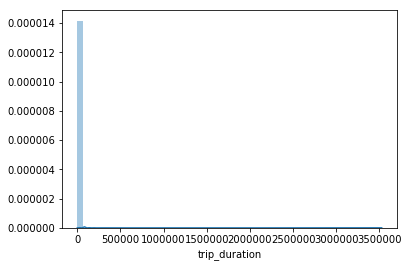

In [4]:

sb.distplot(dataFrame['trip_duration'])

This definitely seems skewed. Lets try to sort the duration in descending order and print the top 20 values

In [5]:
tripDuration=dataFrame['trip_duration']

print "=============================================="
print "20 largest trip durations:"
tripDurDesc=tripDuration.sort_values(ascending=False)
print tripDurDesc[0:20].to_string(index=False)

20 largest trip durations:
3526282
2227612
2049578
1939736
  86392
  86391
  86390
  86387
  86385
  86379
  86378
  86378
  86377
  86377
  86369
  86369
  86369
  86369
  86367
  86367


Yup, the top values do seem highly unlikely (the 4th largest value 1.9M seconds corresponds to around 23 days). Lets see the distribution without these values

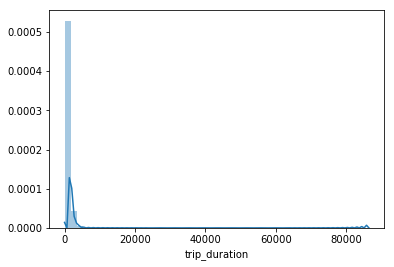

In [6]:
sb.distplot(tripDurDesc[4:])

The shorter values still seem to be skewing the distribution, lets analyze that. I will assume that a trip will be of atleast 60 seconds

20 smallest trip durations:


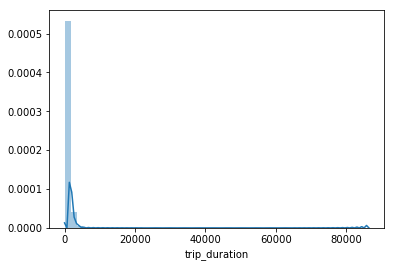

In [7]:
print "=============================================="
print "20 smallest trip durations:"
tripDurAsc=tripDuration.sort_values()
tripDurAsc=tripDurAsc[tripDurAsc<1939736]
tripDurAsc=tripDurAsc[tripDurAsc>=60]
sb.distplot(tripDurAsc)


remove trip duration values < 60 seconds and >=1.9M seconds and then plot the log scale distribution as the loss function is RMSLE

Mean trip duration = 952.815251878
Standard deviation for trip duration = 3171.32119632


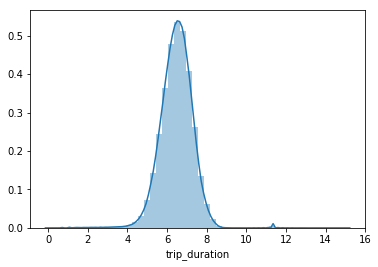

In [8]:
# dF2=dataFrame[dataFrame['trip_duration']<1939736]
# print dF2
dataFrameFiltered=dataFrame[dataFrame['trip_duration']>=60]
dataFrameFiltered =dataFrame[dataFrame['trip_duration']<1939736]
mean = np.mean(dataFrameFiltered['trip_duration'])
print "Mean trip duration =",mean
std=np.std(dataFrameFiltered['trip_duration'])
print "Standard deviation for trip duration =",std
sb.distplot(np.log(tripDuration))


So this is a lognormal distribution. We can take the 4 standard deviation ranges in order to remove even more outliers. 

In [9]:
# tripDuration=dataFrameFiltered['trip_duration']
# tripDuration=tripDuration[tripDuration>=mean-4*std]
# tripDuration=tripDuration[tripDuration<=mean+4*std]
# dataFrameFiltered=dataFrameFiltered[dataFrameFiltered['trip_duration']>=mean-4*std]
# dataFrameFiltered =dataFrameFiltered[dataFrameFiltered['trip_duration']<=mean+4*std]
# sb.distplot(np.log(tripDuration))

Now that we've removed the outliers, lets work on getting some statistics from the data. First of all lets see the traffic in weekdays/weekends as I think weekdays should have more traffic due to office going people

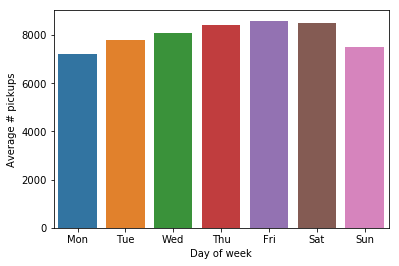

In [10]:
dataFrame=dataFrameFiltered
pickupDT=pd.to_datetime(dataFrame['pickup_datetime'])
pickupDT=pickupDT.sort_values()
def getAvgPickupsDay(pickupDT):
    avgPickups=np.zeros((7,2))
    prevDate=''
    
    for i,dt in pickupDT.iteritems():
        avgPickups[dt.weekday()][0]+=1
        if dt.date()!=prevDate:
            avgPickups[dt.weekday()][1]+=1
        prevDate=dt.date()
    res=np.zeros(7);
    res=[avgPickups[x][0]/avgPickups[x][1] for x in range(0,len(avgPickups))]
    return res

avg=getAvgPickupsDay(pickupDT)
day=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
ax=sb.barplot(day,avg)
ax.set(xlabel='Day of week', ylabel='Average # pickups')


There is no difference in weekday and weekend data, thus its not a feature of importance. Lets see the trips per vendor

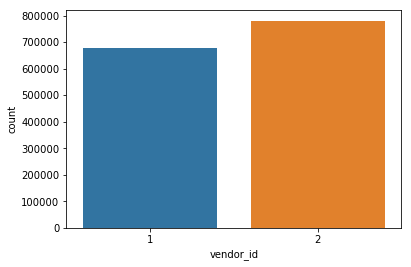

In [11]:
ax=sb.countplot(x='vendor_id',data=dataFrame)

Lets see the number of passengers per vendor

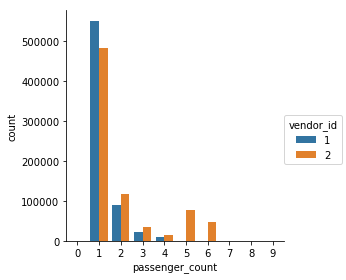

In [12]:
ax=sb.factorplot(x='passenger_count',hue='vendor_id',kind='count',data=dataFrame)

It seems that the taxis operated by vendor 2 carry more passengers than vendor 1 as the larger passenger counts are completely overwhelmed by vendor 2. I guess the vendor id could be a feature but I am not sure as it might not have any effect on the trip duration.

Now lets do some clustering to get an idea of the most dense areas. According to the New York City Borough boundary (https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/nybb_metadata.pdf?ver=17b), these are the extents of NYC:
West -74.257159 East -73.699215
North 40.915568 South 40.495992

Lets remove the data which lies outside the city boundaries first

In [13]:
long_limit=[-74.257159, -73.699215]
lat_limit=[40.495992, 40.915568]
dataFrame=dataFrame[(dataFrame['pickup_longitude']>=long_limit[0])&(dataFrame['pickup_longitude']<=long_limit[1])]
dataFrame=dataFrame[(dataFrame['pickup_latitude']>=lat_limit[0])&(dataFrame['pickup_latitude']<=lat_limit[1])]

AttributeError: 'FacetGrid' object has no attribute 'get_figure'

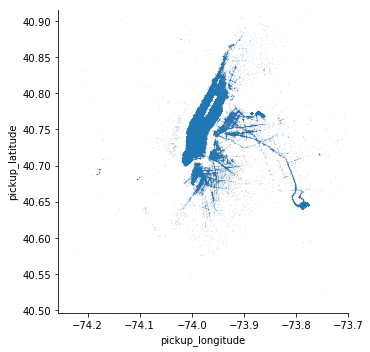

In [32]:
lat=dataFrame['pickup_latitude']
longt=dataFrame['pickup_longitude']
ax=sb.lmplot(x='pickup_longitude',y='pickup_latitude',data=dataFrame,fit_reg=False,scatter_kws={'alpha':0.3,'s':0.05},markers='.')
ax.set(ylim=(lat_limit[0],lat_limit[1]))
ax.set(xlim=(long_limit[0],long_limit[1]))

Based on the above graph, we can see that the majority of the traffic is in manhattan and some parts of Brooklyn, Queens and Bronx. There is some traffic from JFK also. (The deductions were made by taking this map as reference: http://www.nyc.gov/html/dot/images/motorist/2015-06-08-truck-front.jpg)

Lets see the traffic during different time hours

In [ ]:
dataFrameProc=dataFrame.copy()
pdtime=pd.to_datetime(dataFrameProc.pickup_datetime)
ddtime=pd.to_datetime(dataFrameProc.dropoff_datetime)
del dataFrameProc['pickup_datetime']
del dataFrameProc['dropoff_datetime']

In [18]:
dataFrameProc['pickup_date']=pdtime.dt.date
dataFrameProc['pickup_time']=pdtime.dt.time
dataFrameProc['pickup_dow']=pdtime.dt.dayofweek # Pickup day of week
dataFrameProc['pickup_hour']=pdtime.dt.hour
dataFrameProc['dropoff_date']=ddtime.dt.date
dataFrameProc['dropoff_time']=ddtime.dt.time
dataFrameProc['dropoff_dow']=ddtime.dt.dayofweek #Dropoff day of week
dataFrameProc['dropoff_hour']=ddtime.dt.hour

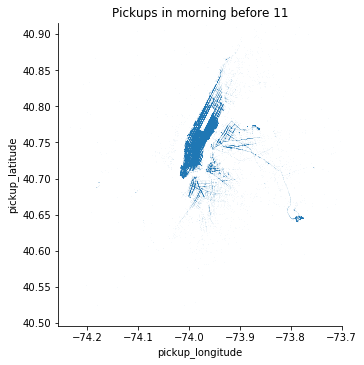

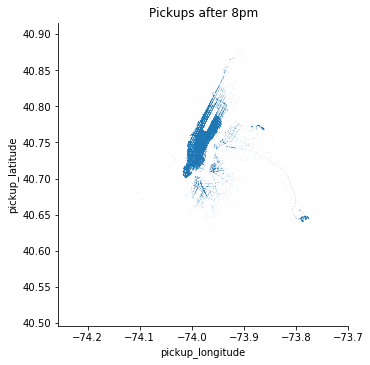

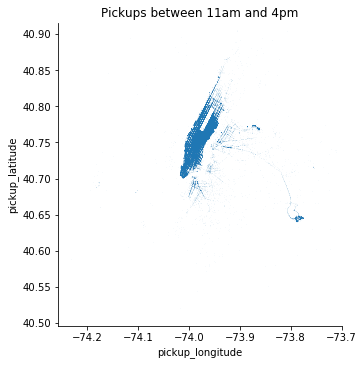

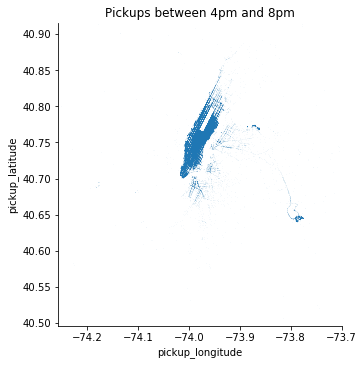

In [16]:
morningTime=dt.datetime.strptime('11:00', '%H:%M').time()
dataFrameMor=dataFrameProc[dataFrameProc['pickup_time']<morningTime]
ax=sb.lmplot(x='pickup_longitude',y='pickup_latitude',data=dataFrameMor,fit_reg=False,scatter_kws={'alpha':0.3,'s':0.005},markers='.')
ax.set(ylim=(lat_limit[0],lat_limit[1]))
ax.set(xlim=(long_limit[0],long_limit[1]))
ax.ax.set_title("Pickups in morning before 11")


nightTime=dt.datetime.strptime('20:00', '%H:%M').time()
dataFrameNgt=dataFrameProc[(dataFrameProc['pickup_time']>=nightTime)]
ax=sb.lmplot(x='pickup_longitude',y='pickup_latitude',data=dataFrameNgt,fit_reg=False,scatter_kws={'alpha':0.3,'s':0.005},markers='.')
ax.set(ylim=(lat_limit[0],lat_limit[1]))
ax.set(xlim=(long_limit[0],long_limit[1]))
ax.ax.set_title("Pickups after 8pm")

afterTime=dt.datetime.strptime('16:00', '%H:%M').time()
dataFrameAft=dataFrameProc[(dataFrameProc['pickup_time']>=morningTime)&(dataFrameProc['pickup_time']<=afterTime)]
ax=sb.lmplot(x='pickup_longitude',y='pickup_latitude',data=dataFrameAft,fit_reg=False,scatter_kws={'alpha':0.3,'s':0.005},markers='.')
ax.set(ylim=(lat_limit[0],lat_limit[1]))
ax.set(xlim=(long_limit[0],long_limit[1]))
ax.ax.set_title("Pickups between 11am and 4pm")

dataFrameEve=dataFrameProc[(dataFrameProc['pickup_time']>=afterTime)&(dataFrameProc['pickup_time']<=nightTime)]
ax=sb.lmplot(x='pickup_longitude',y='pickup_latitude',data=dataFrameEve,fit_reg=False,scatter_kws={'alpha':0.3,'s':0.005},markers='.')
ax.set(ylim=(lat_limit[0],lat_limit[1]))
ax.set(xlim=(long_limit[0],long_limit[1]))
ax.ax.set_title("Pickups between 4pm and 8pm")


There doesn't seem to be much variation between the traffic zones throughout the day. The amount of traffic varies a bit but the areas seem to be the same. I can make clusters from a map of pickup and dropoff points and then use them to determine trip duration but will keep that for later.

Lets see the traffic hours during the days of the week. We can see the average trip duration per hour of each day

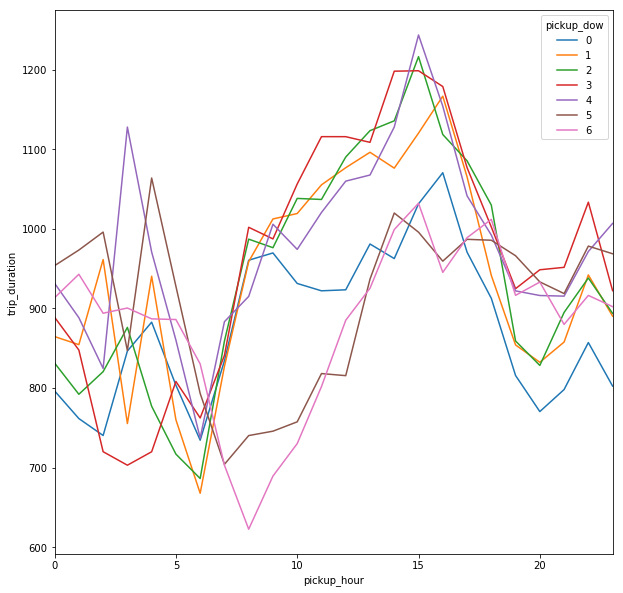

In [31]:
mean_tripDuration_hour_day=pd.DataFrame(dataFrameProc.groupby(by=['pickup_dow','pickup_hour'])['trip_duration'].mean())
mean_tripDuration_hour_day.reset_index(inplace = True)
mean_tripDuration_hour_day['unit']=1
ax=sb.tsplot(mean_tripDuration_hour_day,time="pickup_hour",unit="unit",condition="pickup_dow", value="trip_duration")
ax.get_figure().set_size_inches(10,10)

From the above graph we can see that the weekends have larger trip durations in night and smaller ones during morning and day. Thus day of week and pickup_hour can be good features for trip duration. Now lets see does vendor_id has any effect on trip duration

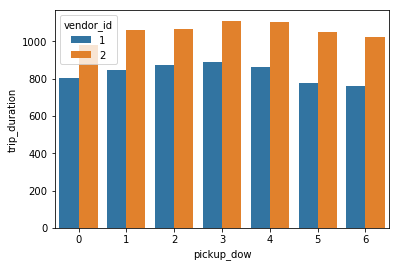

In [37]:
mean_tripDuration_vendor=pd.DataFrame(dataFrameProc.groupby(by=['vendor_id','pickup_dow'])['trip_duration'].mean())
mean_tripDuration_vendor.reset_index(inplace = True)
sb.barplot(data=mean_tripDuration_vendor,x='pickup_dow',y='trip_duration',hue='vendor_id')

As we can see above, vendor 2 has higher trip durations every day of the week. Therefore, vendor_id is a feature of importance. Now lets see if passenger count has any impact on the trip duration

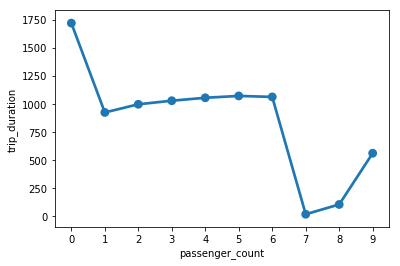

In [42]:
mean_tripDuration_passenger=pd.DataFrame(dataFrameProc.groupby(by=['passenger_count'])['trip_duration'].mean())
mean_tripDuration_passenger.reset_index(inplace = True)
sb.pointplot(x='passenger_count',y='trip_duration',data=mean_tripDuration_passenger)

We can see that the higher passenger counts generally have lower trip durations. I think this could be a feature